# Notebook 03 – Machine Learning Forecasting for SunnyBest

In this notebook, I build machine-learning forecasting models to predict **daily revenue** per store and per product category.

This extends the baseline models from Notebook 02 by introducing:

- Feature engineering  
- Categorical encoding  
- Time-based features  
- Gradient boosting models (XGBoost, LightGBM)  
- Proper time-series validation  

The goal is to create a high-performance forecasting model that will later be deployed through an API and used by the GenAI assistant.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

### 1. Load and prepare merged dataset

In [34]:
df = pd.read_csv("../data/processed/sunnybest_merged_df.csv", parse_dates=["date"], low_memory=False) # low memory removes a warning message

df.head()


,date,store_id,product_id,units_sold,price,regular_price,discount_pct,promo_flag,promo_type,revenue,...,store_type,store_size_store,year,month,day,day_of_week,is_weekend,is_holiday,is_payday,season
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
2,2021-01-01,1,1003,2,399365.0,399365,0,0,NaN,798730.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
3,2021-01-01,1,1004,4,305796.0,305796,0,0,NaN,1223184.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
4,2021-01-01,1,1005,5,462752.0,462752,0,0,NaN,2313760.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry


In [3]:
df.shape

(1227240, 37)

## 2. Selecting Forecasting Level

In [4]:
store_name = "SunnyBest Benin Main"
category = "Mobile Phones"

df_fc = df[(df["store_name"] == store_name) & (df["category"] == category)]
ts = df_fc.groupby("date")["revenue"].sum().reset_index().sort_values("date")


In [5]:
ts

,date,revenue
0,2021-01-01,22549753.0
1,2021-01-02,19388064.0
2,2021-01-03,21155785.0
3,2021-01-04,17087610.0
4,2021-01-05,16450365.0
...,...,...
1456,2024-12-27,20154354.0
1457,2024-12-28,26209820.0
1458,2024-12-29,25352579.0
1459,2024-12-30,21191442.0


### 3. Feature Engineering

In [6]:
ts["day"] = ts["date"].dt.day
ts["month"] = ts["date"].dt.month
ts["year"] = ts["date"].dt.year
ts["dayofweek"] = ts["date"].dt.dayofweek
ts["is_weekend"] = ts["dayofweek"].isin([5,6]).astype(int)


In [7]:
# Add lag

ts["lag_1"] = ts["revenue"].shift(1)
ts["lag_7"] = ts["revenue"].shift(7)
ts["lag_30"] = ts["revenue"].shift(30)
ts["lag_90"] = ts["revenue"].shift(90)


In [8]:
#Add rolling mean
ts["roll_7"] = ts["revenue"].shift(1).rolling(7).mean()
ts["roll_30"] = ts["revenue"].shift(1).rolling(30).mean()


In [9]:
ts = ts.dropna().reset_index(drop=True)
ts.head()


,date,revenue,day,month,year,dayofweek,is_weekend,lag_1,lag_7,lag_30,lag_90,roll_7,roll_30
0,2021-04-01,16119181.0,1,4,2021,3,0,15262573.0,17885621.0,18873078.0,22549753.0,1.820476e+07,1.834048e+07
1,2021-04-02,16696229.0,2,4,2021,4,0,16119181.0,16547448.0,17506700.0,19388064.0,1.795241e+07,1.824868e+07
2,2021-04-03,21325720.0,3,4,2021,5,1,16696229.0,19613306.0,18139723.0,21155785.0,1.797367e+07,1.822167e+07
3,2021-04-04,20025075.0,4,4,2021,6,1,21325720.0,21587795.0,16906672.0,17087610.0,1.821830e+07,1.832787e+07
4,2021-04-05,17705026.0,5,4,2021,0,0,20025075.0,18953373.0,23381744.0,16450365.0,1.799505e+07,1.843181e+07


### 4. Train/Test Split (Time-based)

In [10]:
split = int(len(ts) * 0.8)

train = ts.iloc[:split]
test  = ts.iloc[split:]

X_train = train.drop(["date", "revenue"], axis=1)
y_train = train["revenue"]

X_test = test.drop(["date", "revenue"], axis=1)
y_test = test["revenue"]


### 5. Train baseline ML model: Linear Regression

In [11]:

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)


### 6. Train Random Forest

In [12]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

### 7. Train XGBoost

In [13]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)


### 8. Train LightGBM (Alternative to XGBoost)

In [14]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)
lgb.fit(X_train, y_train)

pred_lgb = lgb.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 11
[LightGBM] [Info] Start training from score 18820221.727190


### 9. Evaluate all Models

In [19]:


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

results = pd.DataFrame({
    "Model": ["LinearRegression", "RandomForest", "XGBoost", "LightGBM"],
    "RMSE": [
        rmse(y_test, pred_lr),
        rmse(y_test, pred_rf),
        rmse(y_test, pred_xgb),
        rmse(y_test, pred_lgb)
    ],
    "MAE": [
        mean_absolute_error(y_test, pred_lr),
        mean_absolute_error(y_test, pred_rf),
        mean_absolute_error(y_test, pred_xgb),
        mean_absolute_error(y_test, pred_lgb)
    ]
})

results = results.sort_values(by="RMSE", ascending=True).reset_index(drop=True)



results


,Model,RMSE,MAE
0,XGBoost,1.888393e+06,1.436590e+06
1,RandomForest,1.934923e+06,1.439285e+06
2,LinearRegression,1.999678e+06,1.518036e+06
3,LightGBM,2.031405e+06,1.536548e+06


### 10. Plot the best model vs actual

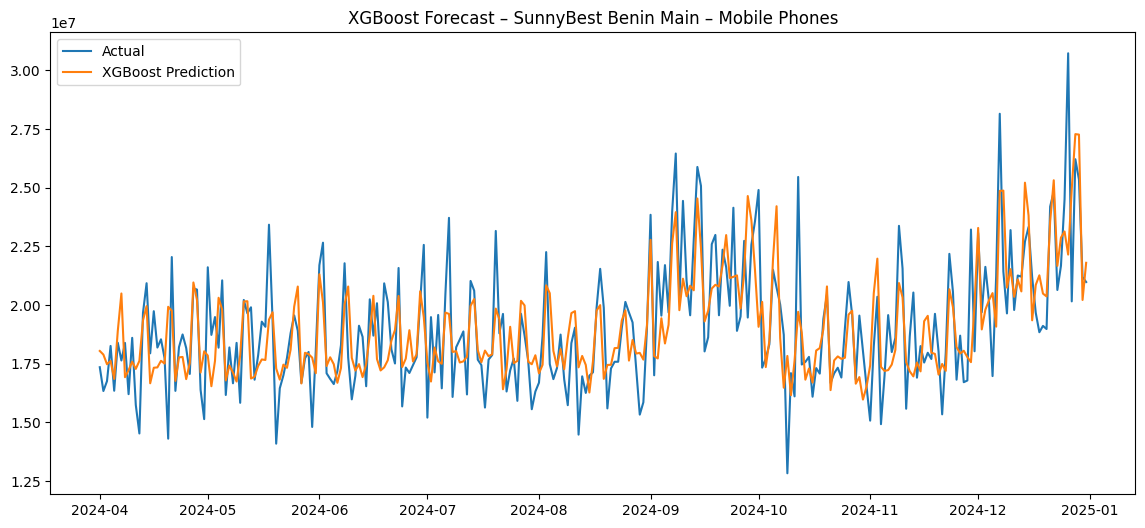

In [21]:
test_plot = test.copy()
test_plot["pred"] = pred_xgb

plt.figure(figsize=(14,6))
plt.plot(test_plot["date"], test_plot["revenue"], label="Actual")
plt.plot(test_plot["date"], test_plot["pred"], label="XGBoost Prediction")
plt.legend()
plt.title(f"XGBoost Forecast – {store_name} – {category}")
plt.show()

### Save Model for Deployment

In [29]:
joblib.dump(xgb, "../models/xgb_revenue_forecast.pkl")


['../models/xgb_revenue_forecast.pkl']

### Load Test

In [30]:
# Load the saved model
loaded_model = joblib.load("../models/xgb_revenue_forecast.pkl")

# Sanity check: predict on the same X_test
y_pred_loaded = loaded_model.predict(X_test)

print("Loaded model RMSE:", rmse(y_test, y_pred_loaded))


Loaded model RMSE: 1888392.9752140224


### Summary

- Trained four models (Linear Regression, Random Forest, XGBoost, LightGBM).
- XGBoost achieved the lowest RMSE and MAE on the hold-out test set.
- Saved the trained XGBoost model to `../models/xgb_revenue_forecast.pkl`.
- Successfully re-loaded the model and reproduced the same forecast performance.

This XGBoost model will be used as the deployed forecasting model in the API and GenAI assistant.
